In [7]:
%load_ext autoreload

In [8]:
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn import metrics

from lightgbm import LGBMRegressor
# from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [12]:
from src.reg_classifier import RegressionClassifier 

In [13]:
# Функция вычисления метрики MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Функция для вычисления всех метрик
def dataframe_metrics(y_test,y_pred):
    stats = [
       metrics.mean_absolute_error(y_test, y_pred),
       np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
       metrics.r2_score(y_test, y_pred),
       mean_absolute_percentage_error(y_test, y_pred)
    ]
    return stats

In [15]:
df = pd.read_csv('./data/AB_NYC_2019_EDA.csv').drop(['Unnamed: 0'], axis=1)

target_name = 'price'

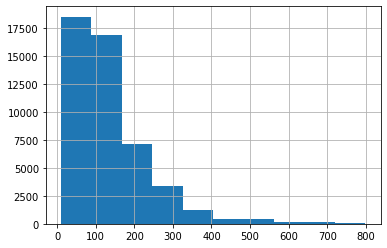

In [16]:
df.price.hist()

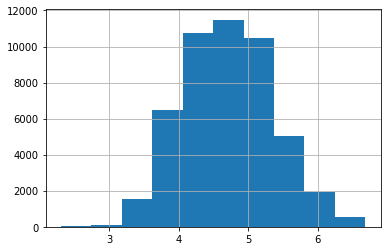

In [17]:
np.log(df.price).hist()

In [18]:
df2 = df.copy()

df2[target_name] = np.log(df[target_name])
#df2 = df

X_train, X_test, y_train, y_test = train_test_split(df2.drop([target_name], axis=1), df2[target_name], test_size=0.3)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [19]:
rc_test = RegressionClassifier()

param_grid = {'N': [3, 7, 10, 20, 30], 'bins_numb': [5, 10, 30, 50]}

rc_gscv = GridSearchCV(rc_test, param_grid, cv=5, n_jobs=-1, scoring='r2')

rc_gscv.fit(X_train_scaled, y_train)

rc_gscv.best_params_

KeyboardInterrupt: 

In [70]:
rc_test = RegressionClassifier(N=3, bins_numb=10)

rc_test.fit(X_train_scaled, y_train)
#rc_test.fit(X_train_scaled, np.log(y_train))

measured_metrics = pd.DataFrame({"error_type":["MAE", "RMSE", "R2", "MAPE"]})
measured_metrics.set_index("error_type")

measured_metrics["rc_test"] = dataframe_metrics(y_test, rc_test.predict(X_test_scaled))
#measured_metrics["rc_test"] = dataframe_metrics(y_test, np.exp(rc_test.predict(X_test_scaled)))
measured_metrics

ValueError: Found input variables with inconsistent numbers of samples: [24, 17]

In [57]:
xgb_reg = XGBRegressor(verbosity = 0)

xgb_reg.fit(X_train_scaled, y_train)

measured_metrics["xgb_reg"] = dataframe_metrics(y_test, xgb_reg.predict(X_test_scaled))
measured_metrics

NameError: name 'XGBRegressor' is not defined

Проверка стабильности модели

In [12]:
scores = cross_validate(rc_test, X_train_scaled, y_train, cv=5, scoring=('r2', 'neg_mean_squared_error'), return_train_score=True, n_jobs=-1)
print(scores['train_neg_mean_squared_error'])
print(scores['train_r2'])
print(scores['test_neg_mean_squared_error'])
print(scores['test_r2'])

[-0.11661205 -0.11658136 -0.11723696 -0.11888126 -0.1180547 ]
[0.72761585 0.72637    0.725883   0.72205884 0.72295908]
[-0.18642034 -0.18586152 -0.1924652  -0.18605377 -0.18825743]
[0.55954751 0.56922653 0.54709065 0.56202164 0.56341309]


In [13]:
scores_reg = cross_validate(xgb_reg, X_train_scaled, y_train, cv=5, scoring=('r2', 'neg_mean_squared_error'), return_train_score=True, n_jobs=-1)
print(scores_reg['train_neg_mean_squared_error'])
print(scores_reg['train_r2'])
print(scores_reg['test_neg_mean_squared_error'])
print(scores_reg['test_r2'])

[-0.10905305 -0.10710484 -0.10743513 -0.11017578 -0.10577764]
[0.74527229 0.7486125  0.7488011  0.74241202 0.75176986]
[-0.15428652 -0.15369848 -0.15639393 -0.15331693 -0.16074472]
[0.63546959 0.64377118 0.63197361 0.63908554 0.62721769]
